# Cross Validation in sklearn

Sources:
* [Efficient LOO Paper](https://pubmed.ncbi.nlm.nih.gov/28469846/)
* [RLS Technical Report](http://cbcl.mit.edu/publications/ps/MIT-CSAIL-TR-2007-025.pdf)
* [sklearn Linear Models User Guide](https://scikit-learn.org/stable/modules/linear_model.html)
* [slkearn Cross Validation User Guide](https://scikit-learn.org/stable/modules/cross_validation.html)

## LASSO, Ridge, and Elastic Net

`sklearn` has built-in functions for identifying cross-validated estimators for each of the models: `LassoCV`, `RidgeCV`, and `ElasticNetCV`.

### Lasso

$$\argmin_{\beta}||y-X\beta||_2^2+\alpha||\beta||_1$$

```Python
LassoCV(eps, n_alphas, cv).fit(X, y)
```
* `eps`: $\frac{\alpha_{min}}{\alpha_{max}} = eps$; default is `1e-3`
* `n_alpha`: number of alphas along the path (length defined by `eps`); default is 100
* `cv`: if an integer is specified, the number of folds; default is 5 (5 folds)

```Python
LassoLarsCV(cv, max_n_alphas).fit(X, y)
```
* `cv`: if an integer is specified, the number of folds; default is 5-fold cross validation
* `max_n_alphas`: the *maximum* number of alphas to try; default is 1000
* the `eps` parameter is available as well, but it is described differently than in `LassoCV`, and its default value is `2.220446...e-16`

`LassoLarsCV` uses the Least Angle Regression (LARS) algorithm and is described as "exploring more relevant values of `alpha`" and faster than `LassoCV` when "the number of samples is very small compared to the number of features." The documentation seems to favor the LARS algorithm in general, but it also notes that LARS is more sensitive to noise and that `LassoCV` is preferable to `LassoLarsCV` for "high-dimensional datasets with many collinear features."

### Ridge

$$\argmin_{\beta}||y-X\beta||_2^2+\alpha||\beta||_2^2$$

```Python
RidgeCV(alphas, cv).fit(X, y)
```
* `alphas`: array of alpha values to dry: defaults to `(0.1, 1.0, 10.0)`
* `cv`: if an integer is specified, the number of folds; defaults to using efficient Leave-One-Out cross validation

Efficient LOO cross validation is evidently a different algorithm that is able to at least approximate the LOO estimator (with a pretty high degree of accuracy if Raoul's code from a few weeks ago is representatitve of the norm).

Ridge is the only model that has efficient LOO cross validation. The documentation argues that in general, 5- or 10-fold cross validation is preferable to LOO, regardless of computational power required to obtain the LOO estimator.

### Elastic Net

$$\argmin_{\beta}||y-X\beta||_2^2+\alpha\rho||\beta||_1 + \frac{\alpha(1-\rho)}{2}||\beta||_2^2 \;\;\text{s.t.}\;\; \rho \in [0,1]$$

`ElasticNetCV` sets both the $\alpha$ and $\rho$ (weight of $L_1$ penalty) parameters.

```Python
ElasticNetCV(l1_ratio, eps, n_alphas, cv).fit(X, y)
```
* `l1_ratio`: if a float in $[0,1]$, the weight of the $L_1$ penalty (and $\rho$ will not be set by the function); if a list of floats in $[0,1]$, a list of weights to try in the cross validation (and $\rho$ will be set by the function); default is 0.5
* `eps`: $\frac{\alpha_{min}}{\alpha_{max}}$; default is `1e-3`
* `n_alphas`: number of alphas along the path (length set by `eps`)
* `cv`: if an integer is specified, the number of folds; default is 5-fold cross validation

## Manual Cross Validation

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import datasets
from sklearn import linear_model

In [6]:
diab = datasets.load_diabetes()
data = np.c_[diab.data, diab.target]
cols = np.append(diab.feature_names, ["Target"])
diab = pd.DataFrame(data, columns = cols)
del(cols, data)

In [24]:
# basic parameters
df = diab
numFolds = 5
alphas = np.linspace(0, 0.01, 100)
outcomeColumn = "Target"

# shuffle and separate into folds
shuffled = df.sample(frac = 1)
result = np.array_split(shuffled, numFolds)

In [18]:
def foldMSE(alph, folds, foldNum):
    # set aside testing fold #i
    testSet = folds[foldNum]
    
    # combine the other (n-1) folds into the training set
    remainingFolds = list(range(len(folds)))
    remainingFolds.remove(foldNum)
    trainSet = pd.concat([folds[i] for i in remainingFolds])

    # convert sets to X and y form for sklearn
    features = list(trainSet.columns)
    features.remove(outcomeColumn)
    train_X = trainSet.loc[:, features]
    train_y = trainSet[outcomeColumn]

    test_X = testSet.loc[:, features]
    test_y = testSet[outcomeColumn]

    # run ridge regression
    ridgeModel = linear_model.Ridge(alpha = alph).fit(train_X, train_y)
    
    # collect MSE from testing set and return
    MSE = np.mean((test_y - ridgeModel.predict(test_X))**2)
    return(MSE)

In [25]:
# dataframe for storing alpha information
alphaDF = pd.DataFrame()
alphaDF["alpha"] = alphas
alphaDF["sumMSE"] = np.nan

# for each alpha
for alpha in alphas:
    sumMSE = 0
    # for each testing fold
    for currentFold in range(numFolds):
        sumMSE += foldMSE(alpha, result, currentFold)
    # save sum of MSEs from each of the n testing folds to the current alpha value
    alphaDF.loc[alphaDF["alpha"] == alpha, "sumMSE"] = sumMSE

# identify alpha with lowest sum MSE
alphaDF.loc[alphaDF["sumMSE"] == min(alphaDF["sumMSE"])]

,alpha,sumMSE
11,0.001111,14850.766298


<AxesSubplot:xlabel='alpha', ylabel='sumMSE'>

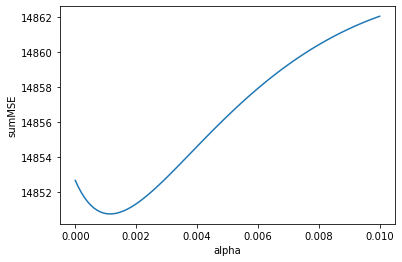

In [26]:
sns.lineplot(x = "alpha", y = "sumMSE", data = alphaDF)